In [1]:
import numpy as np
import pandas as pd
import os
import random
import cv2

from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow.keras.layers as LK
import tensorflow.keras.models as MK
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Para el clasificador se usa el CelebFaces Attributes (CelebA) Dataset de Kaggle
!pip install kaggle
%cd /content/
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json #Para otorgar permisos de escritura y lectura
!kaggle datasets download -d jessicali9530/celeba-dataset

/content
 98% 1.31G/1.33G [00:15<00:00, 161MB/s]
100% 1.33G/1.33G [00:15<00:00, 94.4MB/s]


In [ ]:
!unzip /content/celeba-dataset.zip

In [ ]:
datasetEtiquetas = pd.read_csv('/content/list_attr_celeba.csv')
i=0

print("Las caracteristicas del dataset son:")
for caracteristicas in datasetEtiquetas.columns:
  if i >= 1:
    print(i, ")",caracteristicas)
  i+=1
datasetEtiquetas.head(10)

Las caracteristicas del dataset son:
1 ) 5_o_Clock_Shadow
2 ) Arched_Eyebrows
3 ) Attractive
4 ) Bags_Under_Eyes
5 ) Bald
6 ) Bangs
7 ) Big_Lips
8 ) Big_Nose
9 ) Black_Hair
10 ) Blond_Hair
11 ) Blurry
12 ) Brown_Hair
13 ) Bushy_Eyebrows
14 ) Chubby
15 ) Double_Chin
16 ) Eyeglasses
17 ) Goatee
18 ) Gray_Hair
19 ) Heavy_Makeup
20 ) High_Cheekbones
21 ) Male
22 ) Mouth_Slightly_Open
23 ) Mustache
24 ) Narrow_Eyes
25 ) No_Beard
26 ) Oval_Face
27 ) Pale_Skin
28 ) Pointy_Nose
29 ) Receding_Hairline
30 ) Rosy_Cheeks
31 ) Sideburns
32 ) Smiling
33 ) Straight_Hair
34 ) Wavy_Hair
35 ) Wearing_Earrings
36 ) Wearing_Hat
37 ) Wearing_Lipstick
38 ) Wearing_Necklace
39 ) Wearing_Necktie
40 ) Young


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
6,000007.jpg,1,-1,1,1,-1,-1,1,1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
7,000008.jpg,1,1,-1,1,-1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
8,000009.jpg,-1,1,1,-1,-1,1,1,-1,-1,...,-1,1,-1,-1,1,-1,1,-1,-1,1
9,000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


In [ ]:
#dataset de 2 columnas, reemplazar Male por Genero
datasetEtiquetas = datasetEtiquetas.rename(columns={ 'Male':'Genero' })
clases = []
for col in datasetEtiquetas.columns:
  if col == 'image_id' or col == 'Genero':
    clases.append(datasetEtiquetas[col])
datasetNombreGenero = pd.concat(clases, axis=1)
datasetNombreGenero

,image_id,Genero
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1
...,...,...
202594,202595.jpg,-1
202595,202596.jpg,1
202596,202597.jpg,1
202597,202598.jpg,-1


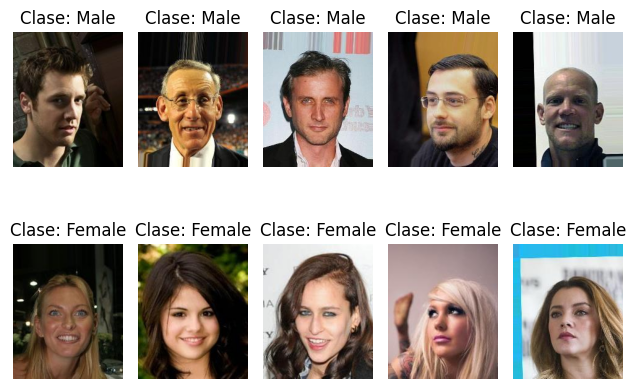

In [ ]:
#visualizador de 5 imágenes originales por categoría

masculino = datasetNombreGenero.loc[datasetNombreGenero['Genero'] == 1]
femenino = datasetNombreGenero.loc[datasetNombreGenero['Genero'] == -1]
raiz = "/content/img_align_celeba/img_align_celeba"
fig, ax = plt.subplots(2,5)
[axi.set_axis_off() for axi in ax.ravel()]
ax = ax.flatten()
cont = 0
for i in ax:
  if cont < 5:
    num = random.randint(0, len(masculino)-1)
    ruta = os.path.join(raiz, masculino.iloc[num][0])
    img = cv2.imread(os.path.join(ruta))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    i.imshow(img)
    i.set_title("Clase: Male")
  else:
    num = random.randint(0, len(femenino)-1)
    ruta = os.path.join(raiz, femenino.iloc[num][0])
    img = cv2.imread(os.path.join(ruta))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    i.imshow(img)
    i.set_title("Clase: Female")
  cont+=1
plt.tight_layout()
plt.show()

In [ ]:
datasetNombreGenero.loc[datasetNombreGenero['Genero'] == -1,'Genero'] = "Female"
datasetNombreGenero.loc[datasetNombreGenero['Genero'] == 1,'Genero'] = "Male"
X = datasetNombreGenero['image_id']
y = datasetNombreGenero['Genero']
print("En total se tienen {} imagenes, de las cuales {} son de hombres y {} de mujeres".format(len(datasetNombreGenero),len(masculino), len(femenino)))

En total se tienen 202599 imagenes, de las cuales 84434 son de hombres y 118165 de mujeres


Los arreglos "X" e "y" almacenarán el total de los datos, correspondiendo al nombre del archivo y su etiqueta de género respectivamente. En el momento de generar el set para entrenamiento y validación sólo se cargará una parte, pues por la gran cantidad de imágenes el modelo podría sobre entrenarse de manera excesiva.

No se considera necesario aplicar ningún preprocesamiento a los datos, primeramente porque el dataset está diseñado desde su origen para este tipo de análisis, donde encontramos imágenes con una misma dimensión, relación de aspecto, proporcionalidad y ubicación de las personas, aunque hayan diferentes posiciones, hay una cantidad de muestras importante por cada una, por lo que facilitará el aprendizaje del modelo.

Por otra parte, se tuvo en cuenta la posibilidad de balancear el dataset en cuanto a sesgo por género, sin embargo, las métricas obtenidas eran inferiores al dataset sin balanceo, por lo cual se decide trabajar sin aplicar esta acción.

Se hace uso de un poco mas del 10% de la totalidad de los datos para entrenar y validar los resultados. Es posible usar todos los datos porque se utiliza un procedimiento donde las imágenes sólo se cargaban en RAM por lotes (BATCH_SIZE) y esto evita el desbordamiento de uso de memoria, pero los tiempos de ejecución eran mas largos.


In [ ]:
category_count = y.value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

Female    118165
Male       84434
Name: Genero, dtype: int64


In [ ]:
datasetPreprocesado = datasetNombreGenero.sample(n=25000, random_state = 42).reset_index(drop=True)
category_count_pp = datasetPreprocesado["Genero"].value_counts()
print(category_count_pp)

higher_category_pp = list(category_count_pp.index)[0]

Female    14492
Male      10508
Name: Genero, dtype: int64


<Axes: >

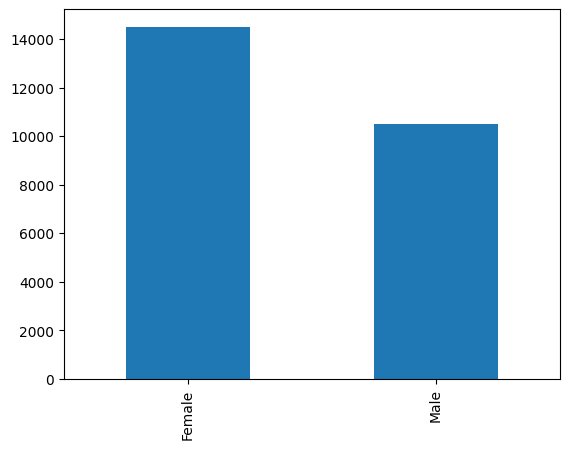

In [ ]:
datasetPreprocesado["Genero"].value_counts().plot.bar()


In [ ]:
#División en datos de entrenamiento y prueba
train_df, test_df = train_test_split(datasetPreprocesado, test_size=0.3, random_state=42)
test_df, validation_df = train_test_split(test_df, test_size=0.33, random_state=42)
print("Total Train Sample Images : ", len(train_df))
print("Total Test Sample Images : ", len(test_df))
print("Total Validation Sample Images : ", len(validation_df))

Total Train Sample Images :  17500
Total Test Sample Images :  5025
Total Validation Sample Images :  2475


### Modelo para clasificación usando como base la arquitectura VGG16

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 300
IMG_PATH = os.path.join('img_align_celeba/img_align_celeba')

In [ ]:
# Generate Train Images Data Generator.
train_datagen = ImageDataGenerator(
    #rotation_range=15,
    rescale=1./255,
    #shear_range=0.1,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #width_shift_range=0.1,
    #height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Genero',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 17500 validated image filenames belonging to 2 classes.


In [ ]:
# Generate Validation Images Data Generator.
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Genero',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 2475 validated image filenames belonging to 2 classes.


In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 5025 validated image filenames.


In [ ]:
base_vgg_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape= IMAGE_SIZE + (3,))

In [ ]:
base_vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
base_vgg_model.trainable = False

In [ ]:
vgg_model = Sequential(
    [
    base_vgg_model,
    Flatten(),
    Dense(1024,activation='relu'),
    Dense(2, activation='sigmoid')
]
)

In [ ]:
vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              25691136  
                                                                 
 dense_7 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 40407874 (154.14 MB)
Trainable params: 25693186 (98.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=1,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000001)
callbacks = [learning_rate_reduction]

In [ ]:
history = vgg_model.fit(train_generator, validation_data = validation_generator
                        , validation_steps=len(validation_df)//BATCH_SIZE
                        ,steps_per_epoch=len(train_df)//BATCH_SIZE,
                        epochs=3, verbose = 1, callbacks=callbacks)

Epoch 1/3
58/58 [==============================] - 95s 2s/step - loss: 1.6481 - accuracy: 0.8044 - val_loss: 0.1909 - val_accuracy: 0.9262 - lr: 0.0010
Epoch 2/3
58/58 [==============================] - 94s 2s/step - loss: 0.1709 - accuracy: 0.9328 - val_loss: 0.1626 - val_accuracy: 0.9379 - lr: 0.0010
Epoch 3/3
58/58 [==============================] - 84s 1s/step - loss: 0.1322 - accuracy: 0.9512 - val_loss: 0.1424 - val_accuracy: 0.9413 - lr: 0.0010


In [ ]:
vgg_model.save("model_vgg16_IDG.h5")

In [ ]:
vgg_modelLoad = tf.keras.models.load_model("/content/model_vgg16_IDG.h5")

In [ ]:
vgg_modelLoad.evaluate(validation_generator)

9/9 [==============================] - 11s 1s/step - loss: 0.1444 - accuracy: 0.9406


[0.14439427852630615, 0.9406060576438904]

In [ ]:
predictor = vgg_modelLoad.predict(test_generator, steps=np.ceil(len(test_df)/BATCH_SIZE))

17/17 [==============================] - 21s 1s/step


In [ ]:
prediction = predictor.argmax(axis=-1)
test_df['Prediction'] = ["Male" if ele == 1 else "Female" for ele in prediction]

In [ ]:
test_df.head(20)

,image_id,Genero,Prediction
15943,099480.jpg,Male,Male
20320,149719.jpg,Male,Male
2255,101583.jpg,Female,Female
3639,194867.jpg,Male,Male
11654,127127.jpg,Female,Female
23097,179999.jpg,Female,Female
11229,126036.jpg,Female,Female
16089,045339.jpg,Female,Female
714,008011.jpg,Female,Female
3043,078646.jpg,Female,Female


In [ ]:
labels = ['Male','Female']
cm = confusion_matrix(test_df['Genero'], test_df["Prediction"], labels= labels)
cm

array([[1892,  199],
       [ 141, 2793]])

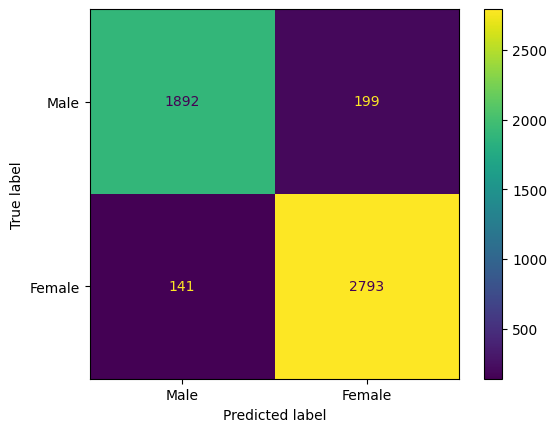

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

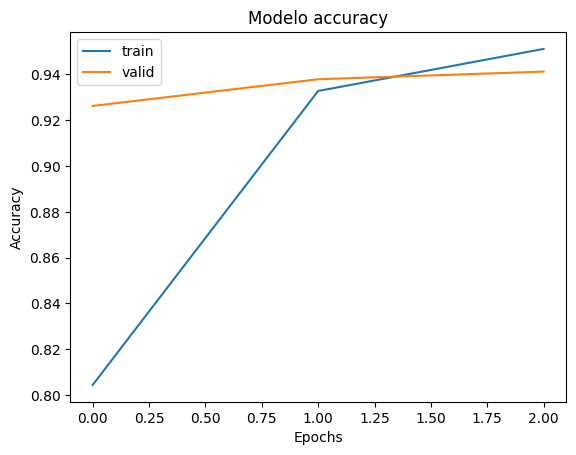

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','valid'],loc='upper left')

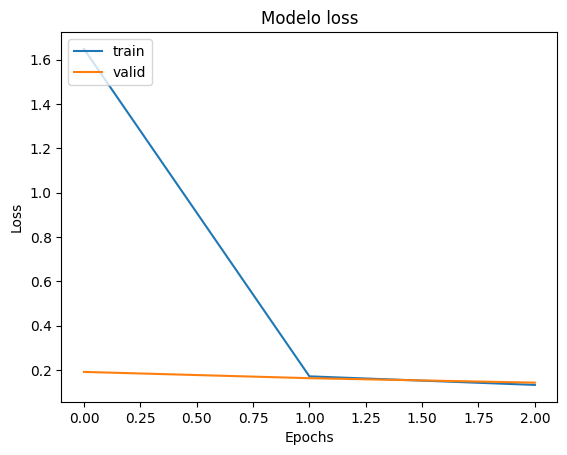

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelo loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','valid'],loc='upper left')

In [ ]:
clf_report = classification_report(test_df['Genero'], test_df["Prediction"])
print(f"CLASSIFICATION REPORT:\n{clf_report}")

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Female       0.93      0.95      0.94      2934
        Male       0.93      0.90      0.92      2091

    accuracy                           0.93      5025
   macro avg       0.93      0.93      0.93      5025
weighted avg       0.93      0.93      0.93      5025



Con los valores obtenidos en las épocas establecidas se controla y evita la presencia de sobreentrenamiento, pues por la tendencia en el accuracy al incrementar las épocas se presentaría el fenómeno.
Lograr las métricas requeridas en pocas épocas fue posible gracias al BATCH_SIZE definido y a la gran cantidad de datos utilizados.

Ahora, revisando la matriz de confusión resultante, se puede comprobar la calidad del modelo obtenido pues:
- Verdaderos positivos (TP): corresponden en este caso a la predicción correcta de mujeres, las cuales fueron 2793.
- Verdaderos negativos (TN): corresponden en este caso a la predicción correcta de hombres, las cuales fueron 1892.
- Falsos positivos (FP): corresponden en este caso a la predicción incorrecta de mujeres, las cuales fueron 199.
- Falsos negativos (FN): corresponden en este caso a la predicción incorrecta de hombres, las cuales fueron 141.

El total de datos de validación fueron 5025, de los cuales se obtiene una exactitud del 93.23% (Acc= (TP+TN)/(TP+FN+TN+FP)), siendo muy cercano al 94% obtenido y presentado al final del entrenamiento con datos de prueba.

El f1-score están entre 92 y 94%, métrica representativa para dataset desbalanceados como lo es en este caso.

### Regularización para mejorar el performance del modelo base.

In [ ]:
base_vgg_model_reg = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape= IMAGE_SIZE + (3,))
base_vgg_model_reg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
base_vgg_model_reg.trainable = False

In [ ]:
learning_rate_reduction_reg = ReduceLROnPlateau(monitor='val_loss',
                                            patience=1,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000001)
callbacks_reg = [learning_rate_reduction_reg]

In [ ]:
vgg_model_reg = Sequential(
    [
    base_vgg_model_reg,
    Flatten(),
    Dense(1024,activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.000001)),
    Dense(2, activation='sigmoid')
]
)
vgg_model_reg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              25691136  
                                                                 
 dense_3 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 40407874 (154.14 MB)
Trainable params: 25693186 (98.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
vgg_model_reg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_reg = vgg_model_reg.fit(train_generator, validation_data = validation_generator,
                                validation_steps=len(validation_df)//BATCH_SIZE,
                                steps_per_epoch=len(train_df)//BATCH_SIZE,
                                epochs=4, verbose = 1, callbacks=callbacks_reg)

Epoch 1/4
58/58 [==============================] - 102s 2s/step - loss: 1.9499 - accuracy: 0.7834 - val_loss: 0.2062 - val_accuracy: 0.9208 - lr: 0.0010
Epoch 2/4
58/58 [==============================] - 92s 2s/step - loss: 0.1798 - accuracy: 0.9312 - val_loss: 0.1625 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 3/4
58/58 [==============================] - 103s 2s/step - loss: 0.1340 - accuracy: 0.9517 - val_loss: 0.1399 - val_accuracy: 0.9442 - lr: 0.0010
Epoch 4/4
58/58 [==============================] - 94s 2s/step - loss: 0.1140 - accuracy: 0.9595 - val_loss: 0.1362 - val_accuracy: 0.9438 - lr: 0.0010


In [ ]:
vgg_model_reg.save("model_reg_vgg16_IDG.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
vgg_model_regLoad = tf.keras.models.load_model("/content/model_reg_vgg16_IDG.h5")

In [ ]:
vgg_model_regLoad.evaluate(validation_generator)

9/9 [==============================] - 12s 1s/step - loss: 0.1337 - accuracy: 0.9446


[0.13371266424655914, 0.9446464776992798]

In [ ]:
predictor_reg = vgg_model_regLoad.predict(test_generator, steps=np.ceil(len(test_df)/BATCH_SIZE))

17/17 [==============================] - 24s 1s/step


In [ ]:
prediction_reg = predictor_reg.argmax(axis=-1)
test_df['Prediction_reg']= ["Male" if ele == 1 else "Female" for ele in prediction_reg]

In [ ]:
labels = ['Male','Female']
cm_reg = confusion_matrix(test_df['Genero'], test_df["Prediction_reg"], labels= labels)
cm_reg

array([[1964,  127],
       [ 195, 2739]])

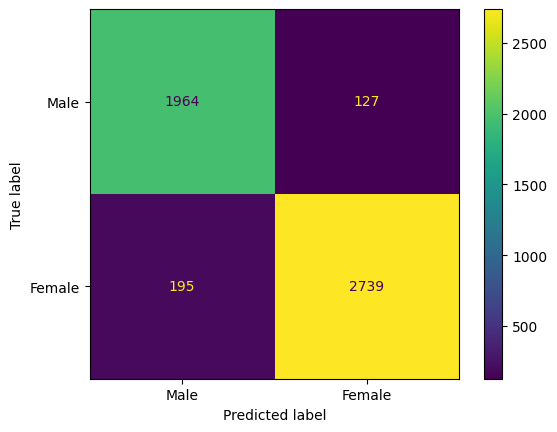

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reg,display_labels=labels)
disp.plot()
plt.show()

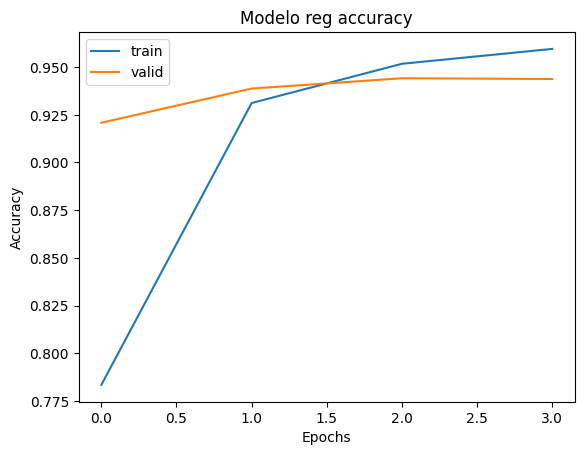

In [ ]:
plt.plot(history_reg.history['accuracy'])
plt.plot(history_reg.history['val_accuracy'])
plt.title('Modelo reg accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','valid'],loc='upper left')

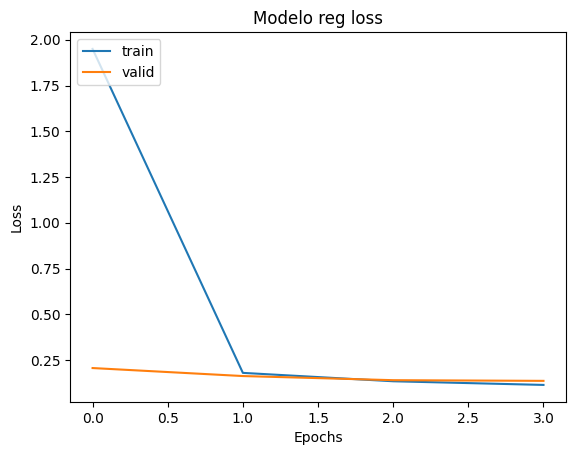

In [ ]:
plt.plot(history_reg.history['loss'])
plt.plot(history_reg.history['val_loss'])
plt.title('Modelo reg loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','valid'],loc='upper left')

In [ ]:
clf_report = classification_report(test_df['Genero'], test_df["Prediction_reg"])
print(f"CLASSIFICATION REPORT:\n{clf_report}")

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Female       0.96      0.93      0.94      2934
        Male       0.91      0.94      0.92      2091

    accuracy                           0.94      5025
   macro avg       0.93      0.94      0.93      5025
weighted avg       0.94      0.94      0.94      5025



Las métricas obtenidas implementando la regularización son mejores que las resultantes del modelo sin ella.

### Uso de transfer learning para entrenar un segundo modelo

In [ ]:
#Se selecciona ResNet50 como modelo base. include_top=false porque no se va a usar su capa clasificadora
tf_ResNet50 = keras.applications.ResNet50(include_top=False,
                                          weights='imagenet',
                                          input_tensor = LK.Input(shape=(64,64,3))
                                          )

In [ ]:
tf_ResNet50.trainable = False

In [ ]:
IMAGE_SIZE_RestNet50 = (64, 64)

In [ ]:
# Generate Train Images Data Generator.
train_datagen2 = ImageDataGenerator(rescale=1./255)

train_generator2 = train_datagen2.flow_from_dataframe(
    train_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Genero',
    target_size=IMAGE_SIZE_RestNet50,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 17500 validated image filenames belonging to 2 classes.


In [ ]:
# Generate Validation Images Data Generator.
validation_datagen2 = ImageDataGenerator(rescale=1./255)
validation_generator2 = validation_datagen2.flow_from_dataframe(
    validation_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col='Genero',
    target_size=IMAGE_SIZE_RestNet50,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 2475 validated image filenames belonging to 2 classes.


In [ ]:
test_gen2 = ImageDataGenerator(rescale=1./255)
test_generator2 = test_gen2.flow_from_dataframe(
    test_df,
    IMG_PATH + "/",
    x_col='image_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE_RestNet50,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 5025 validated image filenames.


In [ ]:
input = tf_ResNet50.output
flat = LK.Flatten()(input)
FC1 = LK.Dense(1024,activation='relu')(flat)
salida = LK.Dense(2, activation='sigmoid')(FC1)
modelo_tf2 = MK.Model(inputs= tf_ResNet50.input, outputs=salida)
modelo_tf2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_10[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
modelo_tf2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_tf2 = modelo_tf2.fit(train_generator2, validation_data = validation_generator2,
                                validation_steps=len(validation_df)//BATCH_SIZE,
                                steps_per_epoch=len(train_df)//BATCH_SIZE,
                                epochs=10, verbose = 1, callbacks=callbacks_reg)

Epoch 1/10
58/58 [==============================] - 23s 308ms/step - loss: 0.8230 - accuracy: 0.6220 - val_loss: 0.5678 - val_accuracy: 0.7133 - lr: 0.0010
Epoch 2/10
58/58 [==============================] - 17s 288ms/step - loss: 0.5608 - accuracy: 0.7082 - val_loss: 0.5419 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 3/10
58/58 [==============================] - 16s 279ms/step - loss: 0.5344 - accuracy: 0.7317 - val_loss: 0.5194 - val_accuracy: 0.7404 - lr: 0.0010
Epoch 4/10
58/58 [==============================] - 16s 277ms/step - loss: 0.5137 - accuracy: 0.7467 - val_loss: 0.5037 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 5/10
58/58 [==============================] - ETA: 0s - loss: 0.5020 - accuracy: 0.7529
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
58/58 [==============================] - 16s 280ms/step - loss: 0.5020 - accuracy: 0.7529 - val_loss: 0.5245 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 6/10
58/58 [==============================] - 17s 287m

In [ ]:
modelo_tf2.evaluate(validation_generator2)

9/9 [==============================] - 3s 282ms/step - loss: 0.4893 - accuracy: 0.7709


[0.48932722210884094, 0.7709090709686279]

In [ ]:
predictor_tf2 = modelo_tf2.predict(test_generator2, steps=np.ceil(len(test_df)/BATCH_SIZE))

17/17 [==============================] - 62s 373ms/step


In [ ]:
prediction_tf2 = predictor_tf2.argmax(axis=-1)
test_df['Prediction_tf2']= ["Male" if ele == 1 else "Female" for ele in prediction_tf2]

In [ ]:
labels = ['Male','Female']
cm_tf2 = confusion_matrix(test_df['Genero'], test_df["Prediction_tf2"], labels= labels)
cm_tf2

array([[1366,  725],
       [ 449, 2485]])

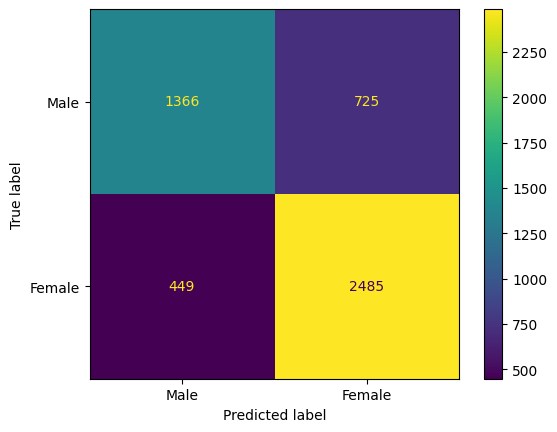

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tf2,display_labels=labels)
disp.plot()
plt.show()

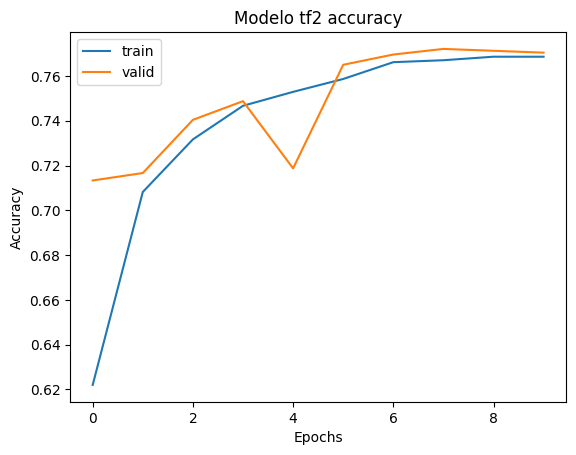

In [ ]:
plt.plot(history_tf2.history['accuracy'])
plt.plot(history_tf2.history['val_accuracy'])
plt.title('Modelo tf2 accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','valid'],loc='upper left')

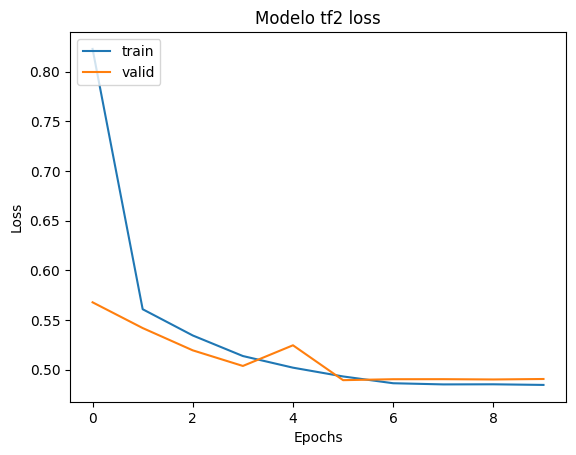

In [ ]:
plt.plot(history_tf2.history['loss'])
plt.plot(history_tf2.history['val_loss'])
plt.title('Modelo tf2 loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','valid'],loc='upper left')

In [ ]:
clf_report = classification_report(test_df['Genero'], test_df["Prediction_tf2"])
print(f"CLASSIFICATION REPORT:\n{clf_report}")

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Female       0.77      0.85      0.81      2934
        Male       0.75      0.65      0.70      2091

    accuracy                           0.77      5025
   macro avg       0.76      0.75      0.75      5025
weighted avg       0.77      0.77      0.76      5025



Aplicando técnicas de regularización se obtiene que el método que mejor se ajusta a los datos usados es L2, esta reduce la dependencia general de los pesos resultantes, sin importar si están fuertemente relacionados con las características mas representativas o no, de esta manera facilita que el modelo pueda generalizar y no se centre en memorizar el comportamiento de manera estricta, lo que mejora la respuesta a datos nuevos.

Al aplicar transfer learning con un modelo diferente, en este caso ResNet50, se obtuvo que las métricas son afectadas en cuanto a magitud, sin embargo, la relación entre resultados de entrenamiento y validación es muy cercana, tanto así que podría iterar algunas veces mas y el riesgo de overfitting es muy bajo.

Para ejercicios donde se requiere velocidad de respuesta sin una exigencia mayor en la calidad es de gran utilidad aplicar transfer learning, pues utiliza modelos con pesos previamente entrenados, por tanto el entrenamiento con nuevos datos no es profundo sino centrado en la variable objetivo.